# SVM Classifier using Wi-Fi data

<p>Jupyter Notebook which aims to explore the ML algorithm Support Vector Machine as a Classifier algorithm using the Wi-Fi technology moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
def find_beacon_index():
    first_beacon_index = -1
    for ap in dataset.iloc[:,4:]:
        if ap.islower() == False:
            first_beacon_index = list(dataset).index(ap)
            break
    return first_beacon_index

In [4]:
dataset = load_file('../radiomapBluetoothWiFiclassifier.csv')
beacon_index = find_beacon_index()
X_train = dataset.iloc[:,4:beacon_index]
Y_train = dataset.iloc[:,3:4]
nan_filler = X_train.min().min()*1.010
X_train = X_train.replace(0, np.nan)
X_train = X_train.fillna(nan_filler)

## Access Points Graphical Display
Graphical display with the average strength signal transmitted by each access point

<BarContainer object of 15 artists>

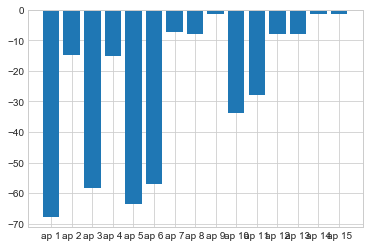

In [5]:
count_aps = {}
counter = 1
first_beacon_index = -1
for ap in X_train:
    mean_value = dataset[ap].mean()
    count_aps['ap ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_aps)),list(count_aps.values()),align='center',tick_label=list(count_aps.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

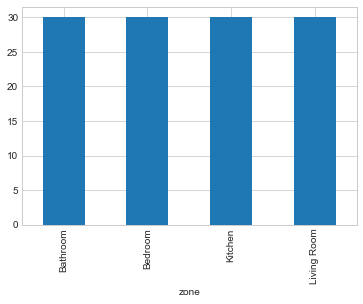

In [6]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

### Wifi Signal Strength

Text(0, 0.5, 'Probability')

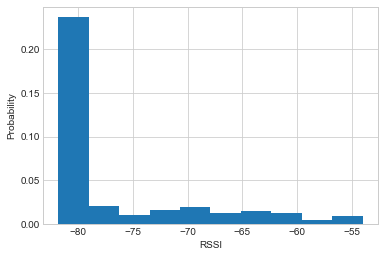

In [7]:
flatten_results = X_train.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize SVM Parameters arrays
Initialization of the arrays with the different possible values for the parameters of SVM Classifier function

In [8]:
#SVM Configurable Arrays
C_parameter_list = [0.25,0.5,1.0,10.0,100.0,1000.0] 
kernel_list = ["linear","poly","rbf","sigmoid"]
filters_list = ["Median","Mean","No Filter"]
gamma_list = [10,100,"scale","auto"]
scaler_list = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
class_weights_list = ["balanced",None]
decision_function_shape_list = ["ovo","ovr"]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["zone"].map(str)

## Statistics Output Format
Structure of the statistical output of each call to the SVM Classification Function

In [9]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

## Configurable SVM Classifier Function 

In [10]:
def compute_SVM_with_Classifier(flag = 1,trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = StandardScaler(),
                                cross_validation = None,C_parameter = 1.0, kernel_parameter='rbf', gamma_parameter="scale", 
                                class_weigth_parameter=None, decision_function_shape_parameter='ovr'):
    # Init the SVM
    svm_classifier_estimator = SVC(C=C_parameter,kernel=kernel_parameter,gamma=gamma_parameter,class_weight=class_weigth_parameter,
                                  decision_function_shape=decision_function_shape_parameter,random_state = 6)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,svm_classifier_estimator)
    else:
        main_estimator = svm_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data.values.ravel())
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data.values,testY_data.values.ravel(),cv = cross_validation,groups=default_data_scenario_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    # Structure data to statistics
    statistics = pd.DataFrame(report).transpose()
    statistical_array = list()
    coord_cols = ['zone']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    error = pd.DataFrame(np.where(predictions[coord_cols] != result[coord_cols],1,0), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    if flag == 0:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(result)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

## Experiments

### 1st Experiment - Running SVM function with default parameters and testing data equal to training data

In [11]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_SVM_with_Classifier(flag=0,trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

Confusion Matrix:
[[29  0  1  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 1  0  0 29]]


,precision,recall,f1-score,support
Bathroom,0.966667,0.966667,0.966667,30.000000
Bedroom,1.000000,1.000000,1.000000,30.000000
Kitchen,0.967742,1.000000,0.983607,30.000000
Living Room,1.000000,0.966667,0.983051,30.000000
accuracy,0.983333,0.983333,0.983333,0.983333
macro avg,0.983602,0.983333,0.983331,120.000000
weighted avg,0.983602,0.983333,0.983331,120.000000


,zone,zone_predicted,error
0,Kitchen,Kitchen,0
1,Kitchen,Kitchen,0
2,Kitchen,Kitchen,0
3,Kitchen,Kitchen,0
4,Kitchen,Kitchen,0
...,...,...,...
115,Bathroom,Bathroom,0
116,Bathroom,Bathroom,0
117,Bathroom,Bathroom,0
118,Bathroom,Bathroom,0


,mae,mse,rmse,precision,accuracy,f1-score
0,0.016667,0.016667,0.129099,0.983564,0.983333,0.983331


### 2nd Experiment - Tunning parameters with GridSearchCV

In [12]:
def tune_parameters():
    results = []
    tuned_parameters = {
        'svc__kernel':kernel_list,
        'svc__C':C_parameter_list,
        'svc__gamma':gamma_list,
        'svc__class_weight':class_weights_list,
        'svc__decision_function_shape':decision_function_shape_list
    }
    scores = ['precision', 'recall','f1']
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        pipe = Pipeline([('standardizer', StandardScaler()), ('svc', SVC())])
        clf = GridSearchCV(
           pipe, tuned_parameters, scoring='%s_macro' % score,n_jobs=-1
        )
        clf.fit(X_train,Y_train.values.ravel())
        clf.best_params_['score'] = score
        results.append(clf.best_params_)
    gridcv_results = pd.DataFrame(results)
    display(gridcv_results)
        

In [13]:
tune_parameters()

# Tuning hyper-parameters for precision

# Tuning hyper-parameters for recall

# Tuning hyper-parameters for f1



,svc__C,svc__class_weight,svc__decision_function_shape,svc__gamma,svc__kernel,score
0,0.5,balanced,ovo,10,linear,precision
1,0.5,balanced,ovo,10,linear,recall
2,0.5,balanced,ovo,10,linear,f1


### 3th Experiment - Running the SVM function with default parameters and Hold-out Cross Validation

,mae,mse,rmse,precision,accuracy,f1-score,test_size
0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.1
3,0.062500,0.062500,0.250000,0.942602,0.937500,0.938097,0.4
2,0.083333,0.083333,0.288675,0.925325,0.916667,0.917647,0.3
4,0.100000,0.100000,0.316228,0.902679,0.900000,0.900906,0.5
6,0.107143,0.107143,0.327327,0.899252,0.892857,0.893535,0.7
5,0.111111,0.111111,0.333333,0.894416,0.888889,0.889823,0.6
1,0.125000,0.125000,0.353553,0.892857,0.875000,0.876855,0.2
7,0.197917,0.197917,0.444878,0.831963,0.802083,0.799462,0.8
8,0.490741,0.490741,0.700529,0.565743,0.509259,0.501415,0.9


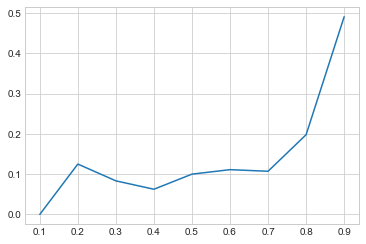

In [14]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    y_train_split = y_train_split.reset_index(drop=True)
    y_test_split = y_test_split.reset_index(drop=True)
    result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae'],))
plt.plot(statistics['test_size'],statistics['mae'])

### 4th Experiment -  Running the SVM function with default parameters and Stratified K-Fold cross validation

,mae,mse,rmse,precision,accuracy,f1-score,folds
5,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,7
6,0.075000,0.075000,0.273861,0.927722,0.925000,0.925026,8
8,0.075000,0.075000,0.273861,0.928075,0.925000,0.924953,10
7,0.091667,0.091667,0.302765,0.912011,0.908333,0.908283,9
4,0.100000,0.100000,0.316228,0.904556,0.900000,0.899632,6
2,0.108333,0.108333,0.329140,0.893806,0.891667,0.891095,4
3,0.116667,0.116667,0.341565,0.892007,0.883333,0.882191,5
0,0.225000,0.225000,0.474342,0.779700,0.775000,0.775533,2
1,0.366667,0.366667,0.605530,0.636305,0.633333,0.628759,3


Number of Folds:  7


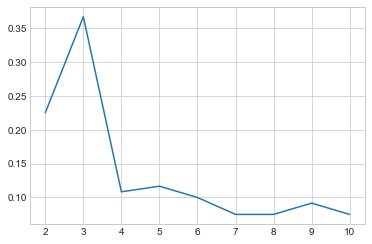

In [15]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,11)
results = list()
for cv in cross_validation_list:
    result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### 6th Experiment -  Running the SVM function with default parameters and Leave One Group Out cross validation

In [16]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,default_data_scenario_groups,groups=default_data_scenario_groups)
loo = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


### 7TH Experiment - Compare cross validation methods

,mae,mse,rmse,precision,accuracy,f1-score,method
2,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,Stratified K-Fold
1,0.490741,0.490741,0.700529,0.565743,0.509259,0.501415,HoldOut
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO


Selected cross validation method:  Stratified K-Fold


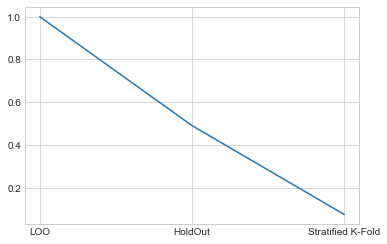

In [17]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method']
results = list()
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)
y_test_split = y_test_split.reset_index(drop=True)
holdout = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skfold = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 8th Experiment - Running the SVM function with the different C parameter values

,mae,mse,rmse,precision,accuracy,f1-score,C_parameter
3,0.050000,0.050000,0.223607,0.950906,0.950000,0.950226,10.00
2,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,1.00
0,0.108333,0.108333,0.329140,0.896773,0.891667,0.890774,0.25
4,0.108333,0.108333,0.329140,0.900121,0.891667,0.892480,100.00
5,0.108333,0.108333,0.329140,0.900121,0.891667,0.892480,1000.00
1,0.116667,0.116667,0.341565,0.887302,0.883333,0.882641,0.50


Selected C Parameter:  10.0


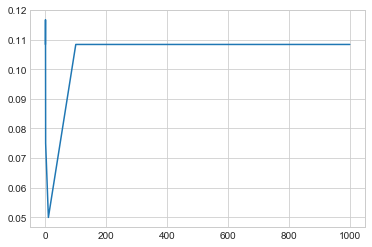

In [18]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','C_parameter']
results = list()
for c_param in C_parameter_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           C_parameter = c_param)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                             cross_validation = selected_fold, C_parameter = c_param) 
    else:
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            C_parameter = c_param) 
    result.append(c_param)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['C_parameter'],statistics['mae'])
selected_c_parameter = statistics.sort_values(by=['mae'])['C_parameter'].head(1).values[0]
print("Selected C Parameter: ",selected_c_parameter)

### 9th Experiment - Running the SVM function with the different preprocessing methods

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc
2,0.025000,0.025000,0.158114,0.975461,0.975000,0.975115,MaxAbsScaler,MaxAbsScaler(copy=True)
3,0.025000,0.025000,0.158114,0.975461,0.975000,0.975115,None,None
1,0.041667,0.041667,0.204124,0.960133,0.958333,0.958663,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))"
0,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,StandardScaler,"StandardScaler(copy=True, with_mean=True, with..."


Selected Preprocessing:  MaxAbsScaler


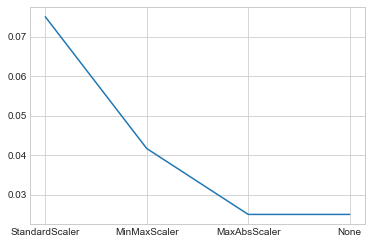

In [19]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = selected_fold)
    else:
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocess)
    if(preprocess is None):
        regex = 'None'
    else:
        regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 10th Experiment - Running the SVM function with the different kernels

,mae,mse,rmse,precision,accuracy,f1-score,kernel
0,0.025000,0.025000,0.158114,0.975461,0.975000,0.975115,linear
2,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,rbf
3,0.083333,0.083333,0.288675,0.922523,0.916667,0.917836,sigmoid
1,0.425000,0.425000,0.651920,0.783242,0.575000,0.572005,poly


Selected Kernel:  linear


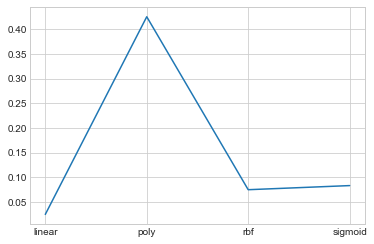

In [20]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','kernel']
results = list()
for kernel in kernel_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            kernel_parameter = kernel)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            kernel_parameter = kernel)
    else:
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            kernel_parameter = kernel)
    result.append(kernel)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['kernel'],statistics['mae'])
selected_kernel = statistics.sort_values(by=['mae'])['kernel'].head(1).values[0]
print("Selected Kernel: ",selected_kernel)

### 11th Experiment - Running the SVM function with the different gamma metrics

,mae,mse,rmse,precision,accuracy,f1-score,gamma,gammaStr
2,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,scale,scale
3,0.075000,0.075000,0.273861,0.927349,0.925000,0.924749,auto,auto
0,0.433333,0.433333,0.658281,0.679145,0.566667,0.581411,10,10
1,0.658333,0.658333,0.811377,0.598707,0.341667,0.323386,100,100


Selected Gamma:  scale


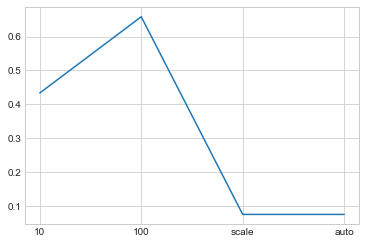

In [21]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','gamma','gammaStr']
results = list()
for gamma in gamma_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            gamma_parameter= gamma)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            gamma_parameter= gamma)
    else:
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            gamma_parameter= gamma)
    result.append(gamma)
    result.append(str(gamma))
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['gammaStr'],statistics['mae'])
selected_gamma_metric = statistics.sort_values(by=['mae'])['gamma'].head(1).values[0]
print("Selected Gamma: ",selected_gamma_metric)

### 12th Experiment:  Running the SVM function with the different weights metrics

,mae,mse,rmse,precision,accuracy,f1-score,class_weights
0,0.075,0.075,0.273861,0.927349,0.925,0.924749,balanced
1,0.075,0.075,0.273861,0.927349,0.925,0.924749,None


Selected Weight:  balanced


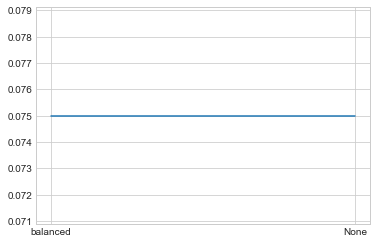

In [22]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','class_weights']
results = list()
for weight in class_weights_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            class_weigth_parameter= weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            class_weigth_parameter= weight)
    else:
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            class_weigth_parameter= weight)
    result.append(str(weight))
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['class_weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['class_weights'].head(1).values[0]
print("Selected Weight: ",selected_weight)

### 13th Experiment:  Running the SVM function with the different decision function metrics

,mae,mse,rmse,precision,accuracy,f1-score,decision_function
0,0.075,0.075,0.273861,0.927349,0.925,0.924749,ovo
1,0.075,0.075,0.273861,0.927349,0.925,0.924749,ovr


Selected Decision Function:  ovo


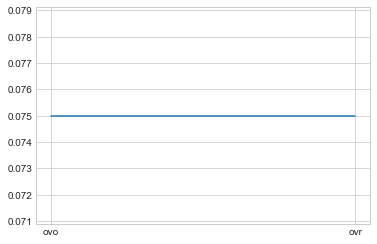

In [23]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','decision_function']
results = list()
for decision in decision_function_shape_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            decision_function_shape_parameter= decision)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            decision_function_shape_parameter= decision)
    else:
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            decision_function_shape_parameter= decision)
    result.append(str(decision))
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['decision_function'],statistics['mae'])
selected_decision = statistics.sort_values(by=['mae'])['decision_function'].head(1).values[0]
print("Selected Decision Function: ",selected_decision)

### 14th Experiment: Running the KNN function with data filtered 

In [24]:
def apply_filter():
    statistical_cols =  ['mae','mse','rmse','precision','accuracy','f1-score','filter']
    results = list()
    for filterelement in filters_list:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_SVM_with_Classifier(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,cross_validation = selected_fold,
                                                 C_parameter = selected_c_parameter, kernel_parameter=selected_kernel, 
                                                 gamma_parameter=selected_gamma_metric,  class_weigth_parameter=selected_weight, 
                                                 decision_function_shape_parameter=selected_decision)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        medians_list = [rp]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,1:]
    y_train = median_pd.iloc[:,0:1]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_SVM_with_Classifier(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 C_parameter = selected_c_parameter, kernel_parameter=selected_kernel, 
                                                 gamma_parameter=selected_gamma_metric,  class_weigth_parameter=selected_weight, 
                                                 decision_function_shape_parameter=selected_decision)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        means_list = [zone]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,1:]
    y_train = mean_pd.iloc[:,0:1]
    nan_filler = X_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_SVM_with_Classifier(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 C_parameter = selected_c_parameter, kernel_parameter=selected_kernel, 
                                                 gamma_parameter=selected_gamma_metric,  class_weigth_parameter=selected_weight, 
                                                 decision_function_shape_parameter=selected_decision)
    result.append('Mean')
    return result

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,mae,mse,rmse,precision,accuracy,f1-score,filter
2,0.016667,0.016667,0.129099,0.983564,0.983333,0.983331,No Filter
0,0.508333,0.508333,0.712975,0.290520,0.491667,0.356475,Median
1,0.750000,0.750000,0.866025,0.089286,0.250000,0.121429,Mean


Selected Filter:  No Filter


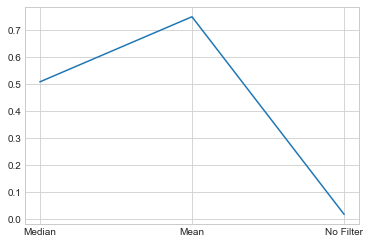

In [25]:
selected_filter = apply_filter()

# Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [26]:
conclusion_cols=['C Parameter','Cross Validation','Kernel','Preprocessing','Gamma','Class Weights','Decision Function','Filtering']
conclusion_list = [selected_c_parameter,selected_method,selected_kernel,selected_preprocessing,selected_gamma_metric,selected_weight,
                  selected_decision,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)
statistical_cols_csv = conclusion_cols
statistical_cols_csv.append('Experimentation')
result_csv = conclusion_list
result_csv.append('SVM Classifier Wifi')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../parameters_svm_results.csv',mode='a',index=False,header=False)

,C Parameter,Cross Validation,Kernel,Preprocessing,Gamma,Class Weights,Decision Function,Filtering
0,10.0,Stratified K-Fold,linear,MaxAbsScaler,scale,balanced,ovo,No Filter


### Best Result

In [27]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
if selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
    result = compute_SVM_with_Classifier(flag= 0,trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,cross_validation = splited,
                                                 C_parameter = selected_c_parameter, kernel_parameter=selected_kernel, 
                                                 gamma_parameter=selected_gamma_metric,  class_weigth_parameter=selected_weight, 
                                                 decision_function_shape_parameter=selected_decision)
elif selected_method =='Stratified K-Fold':
    result = compute_SVM_with_Classifier(flag= 0,trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,cross_validation = selected_fold,
                                                 C_parameter = selected_c_parameter, kernel_parameter=selected_kernel, 
                                                 gamma_parameter=selected_gamma_metric,  class_weigth_parameter=selected_weight, 
                                                 decision_function_shape_parameter=selected_decision) 
else:
    result = compute_SVM_with_Classifier(flag= 0,trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,
                                                 scaler=selected_preprocesssing_func,
                                                 C_parameter = selected_c_parameter, kernel_parameter=selected_kernel, 
                                                 gamma_parameter=selected_gamma_metric,  class_weigth_parameter=selected_weight, 
                                                 decision_function_shape_parameter=selected_decision)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('SVM Classifier Wifi')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../tests_results.csv',mode='a',index=False,header=False)

Confusion Matrix:
[[29  0  1  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 1  0  0 29]]


,precision,recall,f1-score,support
Bathroom,0.966667,0.966667,0.966667,30.000000
Bedroom,1.000000,1.000000,1.000000,30.000000
Kitchen,0.967742,1.000000,0.983607,30.000000
Living Room,1.000000,0.966667,0.983051,30.000000
accuracy,0.983333,0.983333,0.983333,0.983333
macro avg,0.983602,0.983333,0.983331,120.000000
weighted avg,0.983602,0.983333,0.983331,120.000000


,zone,zone_predicted,error
0,Kitchen,Kitchen,0
1,Kitchen,Kitchen,0
2,Kitchen,Kitchen,0
3,Kitchen,Kitchen,0
4,Kitchen,Kitchen,0
...,...,...,...
115,Bathroom,Bathroom,0
116,Bathroom,Bathroom,0
117,Bathroom,Bathroom,0
118,Bathroom,Bathroom,0


,mae,mse,rmse,precision,accuracy,f1-score
0,0.016667,0.016667,0.129099,0.983564,0.983333,0.983331
